# Amazon Customer Reviews - Natural Language Processing
Springboard Data Science Career Track
Capstone 2
by Chantel Clark

## Data
Amazon has an open dataset of over 130 million customer reviews collected between 1995 and 2015, available as URL’s at https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt. Reviews are grouped by product categories such as apparel, automotive, books, e-books, etc. The columns in the dataset include: ‘marketplace’ (country code), ‘customer_id’, ‘review_id’, ‘product_id’, ‘product_parent’ (random identifier for aggregate reviews for the same product), ‘product_title’, ‘product_category’, ‘star_rating’, ‘helpful_votes’, ‘total_votes’, ‘vine’, ‘verified_purchase’, ‘review_headline’, ‘review_body’, ‘review_date’.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import random

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Pandas option - show entire review
pd.set_option('display.max_colwidth', -1)

In [2]:
%%time
# Import Amazon apparel reviews
# Skips 'bad_lines', gets tokenization error without skipping (C error: expected 15 fields, saw 22)
url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz'
url_data = pd.read_table(url, sep='\t', error_bad_lines=False)
url_df = pd.DataFrame(url_data, columns=url_data.keys())
print(url_df.head())

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\nSkipping line 316511: expected 15 fields, saw 22\nSkipping line 317239: expected 15 fields, saw 22\nSkipping line 326099: expected 15 fields, saw 22\nSkipping line 327595: expected 15 fields, saw 22\n'
b'Skipping line 342645: expected 15 fields, saw 22\nSkipping line 347980: expected 15 fields, saw 22\nSkipping line 376258: expected 15 fields, saw 22\nSkipping line 381192: expected 

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     32158956  R1KKOXHNI8MSXU  B01KL6O72Y        24485154   
1          US      2714559  R26SP2OPDK4HT7  B01ID3ZS5W       363128556   
2          US     12608825   RWQEDYAX373I1  B01I497BGY       811958549   
3          US     25482800  R231YI7R4GPF6J  B01HDXFZK6       692205728   
4          US      9310286  R3KO3W45DD0L1K  B01G6MBEBY       431150422   

                                       product_title product_category  \
0  Easy Tool Stainless Steel Fruit Pineapple Core...          Apparel   
1  V28 Women Cowl Neck Knit Stretchable Elasticit...          Apparel   
2  James Fiallo Men's 12-Pairs Low Cut Athletic S...          Apparel   
3  Belfry Gangster 100% Wool Stain-Resistant Crus...          Apparel   
4  JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...          Apparel   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0          4.0            0.0          0.0    N

In [3]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881874 entries, 0 to 5881873
Data columns (total 15 columns):
marketplace          object
customer_id          int64
review_id            object
product_id           object
product_parent       int64
product_title        object
product_category     object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtypes: float64(3), int64(2), object(10)
memory usage: 673.1+ MB


There are 5,881,873 reviews in this dataset.

In [4]:
# Convert 'review_date' column to datetime
url_df['review_date'] = pd.to_datetime(url_df['review_date'])

In [5]:
# Date of the oldest review
min(url_df['review_date'])

Timestamp('2000-09-06 00:00:00')

In [6]:
# Date of the newest review
max(url_df['review_date'])

Timestamp('2015-08-31 00:00:00')

In [7]:
stopwords_english = stopwords.words('english')
print(stopwords_english[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [8]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [9]:
lemmatizer = WordNetLemmatizer()

# Function to tokenize and stem, citation: 
# adapted from http://brandonrose.org/clustering on April 10, 2020
def tokenize_lem(text):
    # Tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Filter tokens not containing letters
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #stems = [stemmer.stem(t) for t in filtered_tokens]
    lemmas = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lemmas

## Apparel dataset

In [10]:
len(url_df)

5881874

### Feature engineering

In [11]:
# Import list of customer id's of suspects (those who write more than 30 or more reviews within a day)
import pickle

with open('suspects.pkl', 'rb') as f:
    suspects30 = pickle.load(f)

In [12]:
suspects30[:10]

[50612720,
 33883540,
 33924372,
 32254988,
 12919673,
 14230771,
 19672530,
 37965911,
 11232231,
 27589096]

In [13]:
# Create boolean 'suspect' column
url_df['suspect'] = 0

# Create non_suspect, copy of url_df
non_suspect = url_df.copy()

In [14]:
%%time
# Create a dataframe of just the suspects, suspects_df, and a dataframe of non-suspects, non_suspect
suspects_df = pd.DataFrame(columns = url_df.columns)
for cid in suspects30:
    boolean = url_df.customer_id == cid
    # Set suspect = 1 in url_df
    url_df['suspect'].loc[boolean] = 1
    
    temp = url_df[boolean]
    # drop the suspects from non_suspect df
    non_suspect.drop(temp.index, inplace=True)
    # append temp to suspects_df
    suspects_df = pd.concat([suspects_df, temp], ignore_index=True)

C:\Users\chant\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Wall time: 7min 23s


In [15]:
suspects_df.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,suspect
0,US,50612720,RHNSTL5UZQQTS,B002TPMFL6,15026908,Tunic Top Cotton Kurti-brown Gold Printed Cott...,Apparel,4.0,0.0,0.0,N,N,women tunic top,Stunning Cotton Kurti with gorgeous colored pr...,2009-10-23,1
1,US,50612720,R2R5WABNC8M64U,B002ON2DB0,744097385,Fashion Blue Skirt Floral Print Fashion Clothe...,Apparel,5.0,0.0,0.0,N,N,Casual Summer Spring Women's Skirt,This classic cotton boho tier skirt are perfec...,2009-09-11,1
2,US,50612720,R2W6U4GDW9Y6GN,B002ON09KC,34396106,Skirts for Women Barmer Print Spring and Summe...,Apparel,4.0,0.0,0.0,N,N,casual summer Spring womens Skirt,This classic cotton boho tier skirt are perfec...,2009-09-11,1


In [16]:
len(non_suspect)

5866513

In [17]:
# How many reviews do not have a review_body?
print(len(non_suspect[non_suspect.review_body.isnull()]), 'from non_suspect')
print(len(suspects_df[suspects_df.review_body.isnull()]), 'from suspects_df')

784 from non_suspect
1 from suspects_df


In [18]:
# Drop null reviews, create Series of reviews
non_suspect_revs = non_suspect.review_body.dropna(axis=0)
suspect_revs = suspects_df.review_body.dropna(axis=0)

In [19]:
print(len(non_suspect_revs))
print(len(suspect_revs))
print(len(non_suspect_revs) + len(suspect_revs))

5865729
15360
5881089


Data is very imbalanced. 

In [20]:
# Remove the reviews (rows) that have no review_body from entire df, url_df
reviews = url_df.review_body.dropna(axis=0)
len(reviews)

5881089

In [21]:
# Number of reviews with no review body
len(url_df) - len(reviews)

785

In [22]:
reviews.head()

0    These Really Do Work Great, But You Do Need To...
1    I love this dress. Absolute favorite for winte...
2    Nice socks, great colors, just enough support ...
3    I bought this for my husband and WOW, this is ...
4    Perfect dress and the customer service was awe...
Name: review_body, dtype: object

In [25]:
suspect_revs[-10:]

15341    Cute lil baby outfit that fit as expected!                                                                                                                                                                                                                                       
15342    Cute lil baby outfit that fit as expected!                                                                                                                                                                                                                                       
15343    Cute lil baby outfit that fit as expected!                                                                                                                                                                                                                                       
15344    Cute lil baby outfit that fit as expected                                                                                                     

In [26]:
non_suspect_revs[-10:]

5881864    As described...this will work perfect for the event we are going to.  Bright color..soft tool...will purchase more items from this seller.                                                                                                                                                                                                                                                                                 
5881865    Not the same color as the picture. More of a darker gold than a bright yellow. Disappointed in the length, longer than expected.                                                                                                                                                                                                                                                                                           
5881866    Exactly what I needed for another costume.  I liked that the tutu was easily trimmed down.                                                     

In [36]:
from wordcloud import WordCloud

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=10000,
        max_font_size=40,
        scale=3,
        random_state=50
    ).generate(str(data))
    fig = plt.figure(figsize=(8,8))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

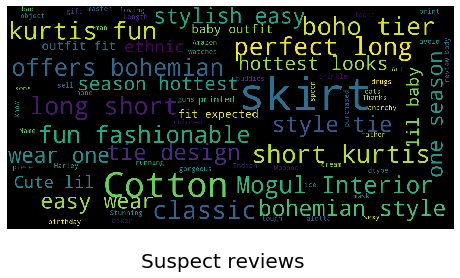

In [37]:
show_wordcloud(suspect_revs, 'Suspect reviews')

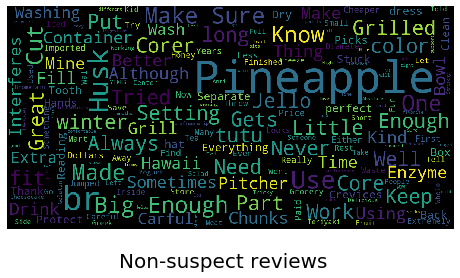

In [35]:
show_wordcloud(non_suspect_revs, 'Non-suspect reviews')

In [28]:
df_copy = url_df.copy()

In [29]:
len(df_copy)

5881874

In [30]:
# Drop rows with Nan's in review_body
df_copy.dropna(subset=['review_body'], inplace=True)
len(df_copy)

5881089

In [31]:
df_copy.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'suspect'],
      dtype='object')

In [32]:
# Create features and targets
X_reviews = df_copy[['review_body', 'customer_id']]
y = df_copy.suspect

In [43]:
# Features + target
X_all = df_copy[['review_body', 'customer_id', 'suspect']]
X_all.tail()

,review_body,customer_id,suspect
5881869,Ok,41086556,0
5881870,Purchased and wore these tutus for the Portland to Coast relay race. The were a one size fits all although we cut off about 12 or more inches as they were too long for our needs. Soft and not at all scratchy.,20641436,0
5881871,"Was kind of long but, had to trim it a bit to fit under my custom made tutu. The color was spot on :)",46003968,0
5881872,What a spectacular tutu! Very slimming.,10988987,0
5881873,"This is thick enough that you can't see through it, but it is very long, so be sure to check the dimensions. I ended up cutting it shorter.",47148712,0


In [84]:
len(X_all)

5881089

In [ ]:
%%time
# Instantiate tfidf vectorizer; for a word to become a feature, it must be in at least 5 different reviews (min_df).
tfidf = TfidfVectorizer(stop_words='english', tokenizer=tokenize_lem, min_df=5)
# Fit and transform reviews
tfidf_matrix = tfidf.fit_transform(X_reviews['review_body'])
tfidf_matrix.shape

579658 features, 57 minutes wall time

91923 features, 59 mins with min_df=5

In [48]:
# Extract list of features
features = tfidf.get_feature_names()
print(features[-10:])

['work/snap', 'worth', 'wow', 'wrong', 'yard', 'year', 'yoga', 'yorkie', 'yr', 'zipper']


In [49]:
print(features[:10])

["'ll", "'m", "'re", "'s", "'ve", '*disclaimer', '6yr', '7-yr', 'able', 'absoloutely']


In [50]:
# Get highest tf-idf scores
feature_array = np.array(features)
transformed = tfidf.transform([reviews[0]])
tfidf_sort = np.argsort(transformed.toarray()).flatten()[::-1]

n = 10
top_n = feature_array[tfidf_sort][:n]

In [51]:
top_n

array(['pineapple', "'s", 'br', 'make', "'ve", 'know', 'sure', 'big',
       'use', 'tried'], dtype='<U17')

## Machine Learning

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

Train test split

In [53]:
# Split the suspects
# Get 80% of the suspicious reviewers for training set
p = 0.8
train_n = round(len(suspects30)*p)
# Set seed and shuffle suspects list
random.Random(48).shuffle(suspects30)
print(len(suspects30))

268


In [54]:
# Split suspects into train and test sets
suspects_train = suspects30[:train_n]
suspects_test = suspects30[train_n:]
# Print number of suspects in training and test sets
print('Number of suspects in training set:', len(suspects_train))
print(suspects_train[:5])
print('Number of suspects in test set:',len(suspects_test))
print(suspects_test[:5])

Number of suspects in training set: 214
[29635366, 3035256, 10948757, 23893822, 17142541]
Number of suspects in test set: 54
[14714515, 46731834, 19606703, 38984110, 19968358]


In [70]:
X_train_suspect = X_all[X_all['customer_id'].isin(suspects_train)].review_body
y_train_suspect = X_all[X_all['customer_id'].isin(suspects_train)].suspect
len(X_train_suspect)

12143

In [71]:
X_test_suspect = X_all[X_all['customer_id'].isin(suspects_test)].review_body
y_test_suspect = X_all[X_all['customer_id'].isin(suspects_test)].suspect
len(X_test_suspect)

3217

In [86]:
non_suspect.dropna(subset=['review_body'], inplace=True)
print(len(non_suspect))

5865729


In [87]:
# Split the non-suspect data
X_train_non, X_test_non, y_train_non, y_test_non = train_test_split(non_suspect['review_body'], non_suspect['suspect'], test_size=0.2, 
                                                    random_state = 0)

In [91]:
# View non-suspect training and test dataset sizes
print(X_train_non.shape)
print(X_test_non.shape)

(4692583,)
(1173146,)


In [89]:
# Concatenate the training sets
X_train = pd.concat([X_train_suspect, X_train_non], ignore_index=True)
y_train = pd.concat([y_train_suspect, y_train_non], ignore_index=True)
# Concatenate the test sets
X_test = pd.concat([X_test_suspect, X_test_non], ignore_index=True)
y_test = pd.concat([y_test_suspect, y_test_non], ignore_index=True)


In [90]:
print(len(X_train))
print(len(X_test))
print(len(X_train) + len(X_test))

4704726
1176363
5881089


## Naive Bayes classifier

In [95]:
# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', tokenizer=tokenize_lem, min_df=5)

In [96]:
# Instantiate Naive Bayes classifier and create pipeline
clf = MultinomialNB()
# Create pipeline
multi_nb = make_pipeline(tfidf, clf)

In [97]:
%%time
multi_nb.fit(X_train, y_train)
multi_nb_ypreds = multi_nb.predict(X_test)

C:\Users\chant\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 59min 13s


In [99]:
# predict probability of classes
yhat = multi_nb.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, pos_probs)

In [98]:
print('Accuracy: {:.2f} %'.format(100 * metrics.accuracy_score(y_test, multi_nb_ypreds)))
print('F-1 score: {:.2f} %'.format(100 * metrics.f1_score(y_test, multi_nb_ypreds)))

Accuracy: 99.70 %
F-1 score: 0.06 %


In [116]:
confusion_matrix(y_test, multi_nb_ypreds)

array([[1172796,     350],
       [   3216,       1]], dtype=int64)

C:\Users\chant\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\chant\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


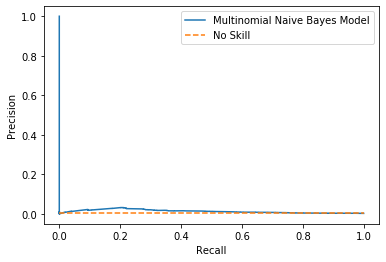

In [100]:
# plot the model precision-recall curve
plt.plot(recall, precision, label='Multinomial Naive Bayes Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
# proportion of suspects in test set
#no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
#plt.legend()

In [101]:
# Naive Bayes AUC
auc(recall, precision)

0.012869931978778372

## Random Forest classifier

In [102]:
%%time
# Fit Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=10)
random_f = make_pipeline(tfidf, clf)
random_f.fit(X_train, y_train)
rf_ypreds = random_f.predict(X_test)

Wall time: 1h 3min 26s


In [104]:
# predict probability of classes
yhat = random_f.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, pos_probs)

In [103]:
print('Accuracy: {:.2f} %'.format(100 * metrics.accuracy_score(y_test, rf_ypreds)))
print('F-1 score: {:.2f} %'.format(100 * metrics.f1_score(y_test, rf_ypreds)))

Accuracy: 99.73 %
F-1 score: 0.00 %


C:\Users\chant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [112]:
confusion_matrix(y_test, rf_ypreds)

array([[1173146,       0],
       [   3217,       0]], dtype=int64)

C:\Users\chant\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\chant\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


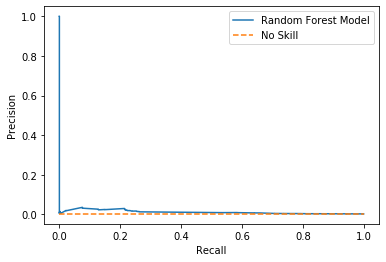

In [105]:
# plot the model precision-recall curve
plt.plot(recall, precision, label='Random Forest Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
# proportion of suspects in test set
#no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
#plt.legend()

In [106]:
# Random forest AUC
auc(recall, precision)

0.0121116396122941

In [107]:
len(y_test[y_test==1])/len(y_test)

0.002734700088323077

## Linear Support Vector Classification

In [117]:
from sklearn.svm import LinearSVC

In [130]:
%%time
clf = LinearSVC()
lsvc = make_pipeline(tfidf, clf)
lsvc.fit(X_train, y_train)
lsvc_ypreds = lsvc.predict(X_test)

Wall time: 1h 9min 38s


In [128]:
# predict probability of classes
#yhat = lsvc.predict(X_test)
# retrieve just the probabilities for the positive class
#pos_probs = len(yhat[yhat==1])/len(yhat)
# calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, lsvc_ypreds)

In [127]:
#len(yhat[yhat==1])/len(yhat)

3.400310958437149e-05

In [131]:
print('Accuracy: {:.2f} %'.format(100 * metrics.accuracy_score(y_test, lsvc_ypreds)))
print('F-1 score: {:.2f} %'.format(100 * metrics.f1_score(y_test, lsvc_ypreds)))
print(confusion_matrix(y_test, lsvc_ypreds))

Accuracy: 99.72 %
F-1 score: 0.06 %
[[1173107      39]
 [   3216       1]]


Text(0, 0.5, 'Precision')

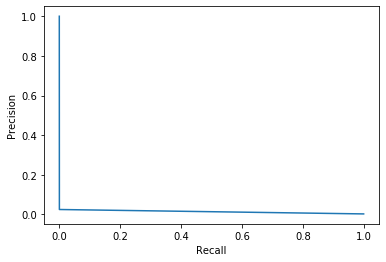

In [132]:
# plot the model precision-recall curve
plt.plot(recall, precision, label='Linear Support Vector Classification')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [137]:
print(metrics.classification_report(y_test, lsvc_ypreds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1173146
           1       0.03      0.00      0.00      3217

    accuracy                           1.00   1176363
   macro avg       0.51      0.50      0.50   1176363
weighted avg       0.99      1.00      1.00   1176363



In [120]:
from sklearn.metrics import plot_confusion_matrix

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (C:\Users\chant\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [134]:
yhat = random_f.predict_proba(X_test)

In [135]:
yhat[:5]

array([[0.9975022 , 0.0024978 ],
       [0.9974374 , 0.0025626 ],
       [0.99742196, 0.00257804],
       [0.99678433, 0.00321567],
       [0.9974023 , 0.0025977 ]])